In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

### Looking at the dataframe and how to impute any missing values

In [2]:
df = pd.read_csv("../order_product.csv")

In [7]:
df.isnull().sum(axis=0)

user_id                   0
product_id                0
date                      0
term                      0
limit                     0
result                    0
city_id                   0
bank_id                   0
product_type              0
guarantee_type            0
loan_term_min             0
loan_term_max             0
loan_term_type            0
decision_cycle            0
loan_cycle                0
repayment_type            0
loan_quota_min            0
loan_quota_max            0
interest_rate_type        0
guarantee_required        0
standard_type             0
apply_num                 0
fangkuan_num              0
is_p2p                    0
id                        0
house_register            0
business_license          0
legal_person              0
married                   0
car                       0
income                    0
house                     0
tax                       0
socialsecurity            0
bank                      0
lifecost            

### Two columns with missing values: early_repayment and penalty
Contingency tables below show there may be a dependence of result on 
the missingness 

In [4]:
df.fillna(-4).groupby('early_repayment')['result'].value_counts(normalize=True).\
    rename('values').reset_index().pivot(index='result', columns='early_repayment', 
            values='values').rename(columns={-4:np.nan})

early_repayment,NaN,0.0,1.0
result,,,
0,0.903471,0.873016,0.794548
1,0.096529,0.126984,0.205452


In [5]:
df.fillna(-4).groupby('penalty')['result'].value_counts(normalize=True).\
    rename('values').reset_index().pivot(index='result',columns='penalty', 
        values='values').rename(columns={-4:np.nan})

penalty,NaN,0.0,1.0
result,,,
0,0.903223,0.85639,0.781994
1,0.096777,0.14361,0.218006


### Set up for random forest classifier

In [8]:
randomforest = RandomForestClassifier()

In [9]:
## for the features I drop the categorical variables that seem to hold limited info
features = df.drop(['user_id','product_id','bank_id','city_id', 'result'], axis=1)
target = df['result']

In [17]:
randomforest.set_params(min_samples_leaf=7)
grid_params = {#'criterion':['gini','entropy'], 
               'max_depth': range(16,19,1),        # 13 range(1, 16, 3)    # 16 range(10,17,2)   # 18
               'max_features': range(6,9,1),      #  8 range(4, 10, 2)    # 8 range(6,11,2)     # 6
        #       'min_samples_leaf': range(1,10,4),  #  7 range(1, 10, 3)    # 9 range(5,10,2)     # 7
               'n_estimators': range(70,100,10)}   # 70 range(10, 100, 20) # 70 range(50,101,20) # 80
grid_search = GridSearchCV(randomforest, grid_params, cv=5, 
                           scoring='balanced_accuracy', n_jobs=-1)

In [14]:
np.arange(1,10,4)

array([1, 5, 9])

#### try with filling the missing values with a completely new number

In [18]:
grid_search.fit(features.fillna(-4), target)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=7,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [20]:
#from joblib import dump
best_est = grid_search.best_estimator_
dump(best_est, 'best_estimator_randomforest_newimputation.joblib')

['best_estimator_randomforest_newimputation.joblib']

In [21]:
grid_search.best_params_ 

{'max_depth': 18, 'max_features': 6, 'n_estimators': 90}

In [22]:
grid_search.best_score_

0.5475776075570247

In [23]:
best_est = grid_search.best_estimator_

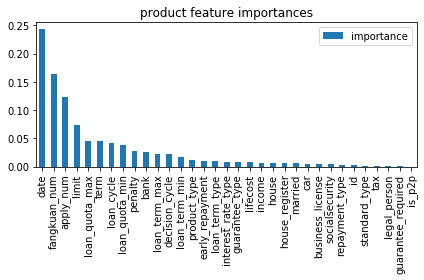

In [35]:
newdf = pd.DataFrame(best_est.feature_importances_, index=features.columns, 
    columns=['importance'])
newdf.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [25]:
best_est.fit(features.fillna(-4), target)
best_est.score(features.fillna(-4), target)

0.8430549346149547

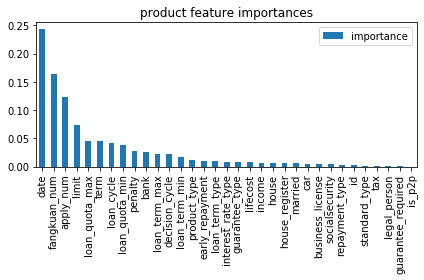

In [26]:
newdf2 = pd.DataFrame(best_est.feature_importances_, index=features.columns, 
    columns=['importance'])
newdf2.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [40]:
newdf.importance.sort_values(ascending=False)[:20].\
to_csv('product_feature_importances.csv', header=['importance'])

In [75]:
important_features = newdf.importance.sort_values(ascending=False)[:20].index.tolist()

### Random Forest with random selection for imputation of missing values

In [27]:
import random

In [6]:
features2 = features.copy()
#column_vals = features2[column].values[features2[column].values != np.nan]
#    features3[column] = features2[column].fillna(random.choice(column_vals))
features2['early_repayment'].fillna(random.choice(features2['early_repayment'].\
    values[features2['early_repayment'].values != np.nan]), inplace=True)
features2['penalty'].fillna(random.choice(features2['early_repayment'].\
    values[features2['penalty'].values != np.nan]), inplace=True)
#grid_search.fit(features.fillna(-4), target)

In [67]:
grid_params = {#'criterion':['gini','entropy'], 
               'max_depth': range(5,15,2), 
               'max_features': range(4,10,2), 
               'min_samples_leaf': range(1,5,1), 
               'n_estimators': range(20,70,10)}
grid_search = GridSearchCV(randomforest, grid_params, cv=5, 
                           scoring='balanced_accuracy', n_jobs=-1)

In [68]:
grid_search.fit(features2, target)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [70]:
grid_search.best_params_

{'max_depth': 13, 'max_features': 8, 'min_samples_leaf': 4, 'n_estimators': 50}

In [71]:
grid_search.best_score_

0.5439140846286917

In [73]:
best_est2 = grid_search.best_estimator_

In [74]:
best_est2.fit(features2, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=13, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [76]:
best_est2.score(features2, target)

0.8360134682016318

In [ ]:
newdf = pd.DataFrame(best_est2.feature_importances_, index=features2.columns, 
    columns=['importance'])
newdf.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

## Random Forest to determine Apply_num

In [3]:
features2 = df.drop(['user_id','product_id','bank_id','city_id', 'apply_num'], axis=1)
target2 = df['apply_num']

In [11]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(features2.fillna(-1), target2)

/Users/jen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

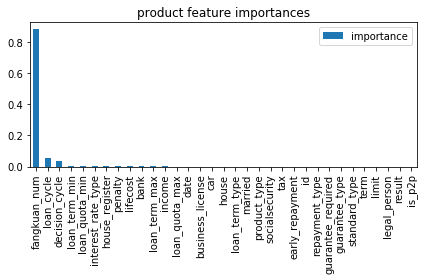

In [91]:
newdf2 = pd.DataFrame(rfr.feature_importances_, index=features2.columns, 
    columns=['importance'])
newdf2.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [5]:
#rfr.set_params(criterion='r2')

RandomForestRegressor(bootstrap=True, criterion='r2', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [35]:
grid_params = {#'max_depth': range(2,21,3), 
               'max_features': range(6,15,1), 
         #      'min_samples_leaf': range(1,6,5), 
              'n_estimators': range(150,301,25)}
grid_search2 = GridSearchCV(rfr, grid_params, cv=5, 
                           scoring='r2', n_jobs=-1)

In [36]:
#np.arange(2,21,3)
#randomforest.set_params(max_depth=10, n_estimators=100)
#randomforest.fit(features2.fillna(-1), target2)
grid_search2.fit(features2.fillna(-1), target2)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_features': range(6, 15),
       

In [37]:
grid_search2.best_params_ # 8 range(2,10,1), 250 range(100,301,50)

{'max_features': 14, 'n_estimators': 275}

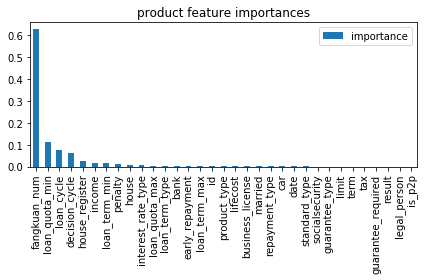

In [38]:
newdf2 = pd.DataFrame(grid_search2.best_estimator_.feature_importances_, index=features2.columns, 
    columns=['importance'])
newdf2.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [44]:
newdf2.importance.sort_values(ascending=False).\
to_csv('product_feature_importances_apply_num.csv', header=['importance'])

### PCA

array([ 10,  40,  70, 100])

### Clustering

In [45]:
from sklearn.cluster import KMeans

In [46]:
kmeans = KMeans()

In [53]:
important_columns = newdf2.importance.sort_values(ascending=False)[:10].index.tolist()

In [57]:
aug_df = df[important_columns].fillna(-1)

In [60]:
aug_df['apply_num'] = df['apply_num']
aug_df

,fangkuan_num,loan_quota_min,loan_cycle,decision_cycle,house_register,income,loan_term_min,penalty,house,interest_rate_type,apply_num
0,8,300000,17,3,1,1,12,0.0,1,0,205
1,943,50000,5,3,0,0,12,-1.0,0,0,3406
2,31,300000,20,3,1,0,12,0.0,1,0,520
3,0,10000,3,1,0,1,12,-1.0,0,0,0
4,23,10000,3,1,1,0,6,1.0,1,0,973
...,...,...,...,...,...,...,...,...,...,...,...
143147,89,50000,2,1,0,0,1,0.0,0,0,539
143148,0,10000,3,0,0,0,12,-1.0,0,0,4
143149,57,10000,3,2,0,0,1,-1.0,1,0,706
143150,1076,50000,3,2,0,0,12,1.0,0,0,3828


In [68]:
# to dummify: penalty, interest_rate_type
to_dummify = []
for column in aug_df.columns:
    print(column)
    print(aug_df[column].nunique())
    if (aug_df[column].nunique() > 2) & (aug_df[column].nunique() < 10): 
        to_dummify.append(column)

fangkuan_num
312
loan_quota_min
42
loan_cycle
42
decision_cycle
17
house_register
2
income
2
loan_term_min
18
penalty
3
house
2
interest_rate_type
3
apply_num
703


In [76]:
new_df = aug_df.copy()
for column in to_dummify:
    new_df = pd.concat([new_df.drop(column, axis=1), pd.get_dummies(aug_df[column], 
                                prefix=column)], axis=1)
#pd.get_dummies(penalty)

In [77]:
new_df.columns

Index(['fangkuan_num', 'loan_quota_min', 'loan_cycle', 'decision_cycle',
       'house_register', 'income', 'loan_term_min', 'house', 'apply_num',
       'penalty_-1.0', 'penalty_0.0', 'penalty_1.0', 'interest_rate_type_0',
       'interest_rate_type_1', 'interest_rate_type_2'],
      dtype='object')

In [78]:
from sklearn.preprocessing import StandardScaler

In [79]:
new_df2 = StandardScaler().fit_transform(new_df)

In [80]:
new_df2

array([[-0.46584651,  0.39502322,  1.91819677, ...,  0.36467627,
        -0.02379396, -0.36367968],
       [ 0.68358492, -0.01654075, -0.02907836, ...,  0.36467627,
        -0.02379396, -0.36367968],
       [-0.43757172,  0.39502322,  2.40501555, ...,  0.36467627,
        -0.02379396, -0.36367968],
       ...,
       [-0.40560892, -0.08239099, -0.35362421, ...,  0.36467627,
        -0.02379396, -0.36367968],
       [ 0.84708693, -0.01654075, -0.35362421, ...,  0.36467627,
        -0.02379396, -0.36367968],
       [ 0.61842998,  0.01638437, -0.35362421, ...,  0.36467627,
        -0.02379396, -0.36367968]])

In [82]:
def plot_inertia(km, X, n_cluster_range):
    inertias = []
    for i in n_cluster_range:
        km.set_params(n_clusters=i)
        km.fit(X)
        inertias.append(km.inertia_)
    plt.plot(n_cluster_range, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

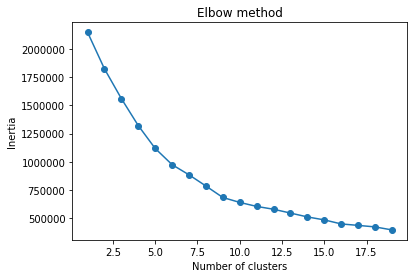

In [83]:
plot_inertia(kmeans, new_df2, range(1,20))

In [84]:
kmeans6 = KMeans().set_params(n_clusters=6)
kmeans6.fit(new_df2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [85]:
kmeans9 = KMeans().set_params(n_clusters=9)
kmeans9.fit(new_df2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [89]:
new_df2

5    56128
4    40489
1    16718
2    11236
0    10079
3     8502
dtype: int64
0    40239
2    31131
7    25383
4    16718
3    11014
5    10079
1     8502
6       81
8        5
dtype: int64


In [90]:
from sklearn.cluster import AgglomerativeClustering
hier = AgglomerativeClustering()

In [52]:
grid_params = {'C': 10.**(np.arange(-7,-2))}
grid_search2 = GridSearchCV(logit2, grid_params, cv=5, 
                           scoring='balanced_accuracy', n_jobs=-1)

In [53]:
grid_search2.fit(features3, target)

/Users/jen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

In [43]:
grid_search2.best_params_

{'C': 1e-05}

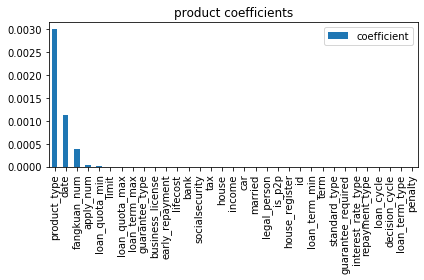

In [45]:
newdf = pd.DataFrame(abs(grid_search2.best_estimator_.coef_.T), 
                     index=features2.columns, columns=['coefficient'])
newdf.sort_values(by='coefficient', ascending=False).plot.bar()
plt.title('product coefficients')
plt.tight_layout()
plt.show()

In [47]:
newdf['coefficient'].sort_values()

penalty               0.000000e+00
house                 0.000000e+00
income                0.000000e+00
car                   0.000000e+00
married               0.000000e+00
legal_person          0.000000e+00
business_license      0.000000e+00
house_register        0.000000e+00
id                    0.000000e+00
is_p2p                0.000000e+00
bank                  0.000000e+00
early_repayment       0.000000e+00
standard_type         0.000000e+00
tax                   0.000000e+00
guarantee_required    0.000000e+00
repayment_type        0.000000e+00
loan_cycle            0.000000e+00
decision_cycle        0.000000e+00
loan_term_type        0.000000e+00
loan_term_min         0.000000e+00
guarantee_type        0.000000e+00
lifecost              0.000000e+00
term                  0.000000e+00
interest_rate_type    0.000000e+00
socialsecurity        0.000000e+00
loan_term_max         5.198193e-09
loan_quota_max        3.730245e-08
limit                 7.485874e-07
loan_quota_min      

In [48]:
grid_search2.fit(features2, target)

/Users/jen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

In [49]:
grid_search2.best_params_

{'C': 0.0001}

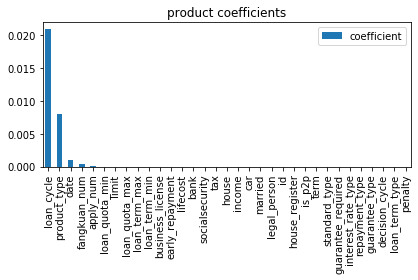

In [50]:
newdf = pd.DataFrame(abs(grid_search2.best_estimator_.coef_.T), 
                     index=features2.columns, columns=['coefficient'])
newdf.sort_values(by='coefficient', ascending=False).plot.bar()
plt.title('product coefficients')
plt.tight_layout()
plt.show()

In [51]:
newdf['coefficient'].sort_values()

penalty               0.000000e+00
income                0.000000e+00
car                   0.000000e+00
married               0.000000e+00
legal_person          0.000000e+00
business_license      0.000000e+00
house_register        0.000000e+00
id                    0.000000e+00
is_p2p                0.000000e+00
socialsecurity        0.000000e+00
early_repayment       0.000000e+00
standard_type         0.000000e+00
guarantee_required    0.000000e+00
interest_rate_type    0.000000e+00
repayment_type        0.000000e+00
bank                  0.000000e+00
decision_cycle        0.000000e+00
loan_term_type        0.000000e+00
loan_term_min         0.000000e+00
guarantee_type        0.000000e+00
lifecost              0.000000e+00
term                  0.000000e+00
house                 0.000000e+00
tax                   0.000000e+00
loan_term_max         5.334704e-09
loan_quota_max        3.072778e-08
limit                 1.695258e-06
loan_quota_min        3.509168e-06
apply_num           

In [2]:
features['fangkuan_num']

NameError: name 'features' is not defined

In [16]:
df2 = pd.read_csv("../order_quality.csv")

In [17]:
df2.dtypes

user_id            object
product_id         object
date                int64
term                int64
limit             float64
                   ...   
mobile_quality    float64
standard_type     float64
guarantee_type    float64
bank_id            object
counts            float64
Length: 95, dtype: object

In [18]:
df2 = df2.drop(df2.columns[df2.isnull().sum()/df2.shape[0] > 0.5], axis=1)

In [19]:
df2.dtypes

user_id                    object
product_id                 object
date                        int64
term                        int64
limit                     float64
result                      int64
city_id                    object
application_type          float64
application_term          float64
application_limit         float64
op_type                   float64
col_type                  float64
user_loan_experience      float64
user_has_car              float64
user_social_security      float64
qid77                     float64
user_income_by_card       float64
user_work_period          float64
loan_limit_n              float64
op_type_n                 float64
col_type_n                float64
user_loan_experience_n    float64
user_has_car_n            float64
user_social_security_n    float64
qid77_n                   float64
cash_receipts_n           float64
user_income_by_card_n     float64
user_work_period_n        float64
user_age_n                float64
product_type  

In [20]:
features2 = df2.drop(['user_id', 'product_id', 'city_id', 'bank_id', 'result'], axis=1)
target2 = df2['result']

In [21]:
features2.isnull().sum(axis=0)

date                           0
term                           0
limit                          0
application_type            4395
application_term            4395
application_limit           4395
op_type                    38550
col_type                  103626
user_loan_experience       87898
user_has_car              120599
user_social_security      138701
qid77                     134258
user_income_by_card       113766
user_work_period          131021
loan_limit_n               36346
op_type_n                  18162
col_type_n                 71512
user_loan_experience_n     51199
user_has_car_n             96613
user_social_security_n    112346
qid77_n                   109724
cash_receipts_n           110110
user_income_by_card_n      81972
user_work_period_n         95672
user_age_n                141002
product_type                4395
apply_from                  4395
platform                    4395
spam_score                  4395
mobile_verify               4395
source    

In [115]:
features2.loc[features2['application_type'].isnull()].isnull().sum()#.sum(axis=0)

date                         0
term                         0
limit                        0
application_type          4395
application_term          4395
application_limit         4395
op_type                   4395
col_type                  4395
user_loan_experience      4395
user_has_car              4395
user_social_security      4395
qid77                     4395
user_income_by_card       4395
user_work_period          4395
loan_limit_n              4395
op_type_n                 4395
col_type_n                4395
user_loan_experience_n    4395
user_has_car_n            4395
user_social_security_n    4395
qid77_n                   4395
cash_receipts_n           4395
user_income_by_card_n     4395
user_work_period_n        4395
user_age_n                4395
product_type              4395
apply_from                4395
platform                  4395
spam_score                4395
mobile_verify             4395
source                    4395
medium                    4395
is_paid 

In [22]:
features2.shape

(282707, 41)

In [23]:
4395/282707

0.015546130799732586

In [135]:
#features2 = features2.loc[~features2['application_type'].isnull()]

In [24]:
features2.fillna(-4, inplace=True)

In [123]:
#features3 = pd.DataFrame()
#for column in features2.columns:
#    column_vals = features2[column].values[features2[column].values != np.nan]
#    features3[column] = features2[column].fillna(random.choice(column_vals))

In [124]:
#features3.isnull().sum(axis=0)

date                      0
term                      0
limit                     0
application_type          0
application_term          0
application_limit         0
op_type                   0
col_type                  0
user_loan_experience      0
user_has_car              0
user_social_security      0
qid77                     0
user_income_by_card       0
user_work_period          0
loan_limit_n              0
op_type_n                 0
col_type_n                0
user_loan_experience_n    0
user_has_car_n            0
user_social_security_n    0
qid77_n                   0
cash_receipts_n           0
user_income_by_card_n     0
user_work_period_n        0
user_age_n                0
product_type              0
apply_from                0
platform                  0
spam_score                0
mobile_verify             0
source                    0
medium                    0
is_paid                   0
quality                   0
mobile_source             0
mobile_medium       

In [110]:
#features3['user_loan_experience'].isnull().sum()

83503

In [25]:
features2.head()

,date,term,limit,application_type,application_term,application_limit,op_type,col_type,user_loan_experience,user_has_car,...,medium,is_paid,quality,mobile_source,mobile_medium,mobile_is_paid,mobile_quality,standard_type,guarantee_type,counts
0,754,24,10.0,1.0,24.0,10.0,-4.0,-4.0,-4.0,-4.0,...,121.0,0.0,0.0,185.0,117.0,0.0,1.0,1.0,1.0,6.0
1,754,24,10.0,2.0,36.0,10.0,2.0,-4.0,-4.0,-4.0,...,121.0,0.0,0.0,185.0,117.0,0.0,1.0,1.0,1.0,6.0
2,754,24,20.0,1.0,12.0,20.0,-4.0,-4.0,-4.0,-4.0,...,57.0,0.0,1.0,221.0,231.0,0.0,1.0,1.0,2.0,6.0
3,754,24,20.0,2.0,24.0,20.0,3.0,-4.0,-4.0,-4.0,...,57.0,0.0,1.0,221.0,231.0,0.0,1.0,1.0,2.0,6.0
4,754,12,10.0,2.0,12.0,10.0,3.0,-4.0,-4.0,-4.0,...,123.0,0.0,0.0,151.0,231.0,0.0,1.0,1.0,1.0,12.0


In [26]:
randomforest2 = RandomForestClassifier()

In [27]:
grid_params2 = { 'max_depth': range(1,10,1), 'n_estimators': range(5,50,5)}
grid_search2 = GridSearchCV(randomforest2, grid_params, cv=5, 
                           scoring='balanced_accuracy', n_jobs=-1)
grid_search2.fit(features2, target2)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [28]:
grid_search2.best_params_

{'max_depth': 9, 'n_estimators': 5}

In [29]:
grid_search2.best_score_

0.5040860806503792

In [30]:
best_est2 = grid_search2.best_estimator_

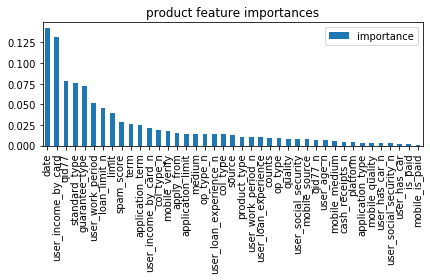

In [31]:
newdf = pd.DataFrame(best_est2.feature_importances_, index=features2.columns, 
    columns=['importance'])
newdf.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [32]:
best_est2 = best_est2.fit(features2, target2)

In [33]:
best_est2.fit(features2, target2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
best_est2.score(features2, target2)

0.8468626528526001

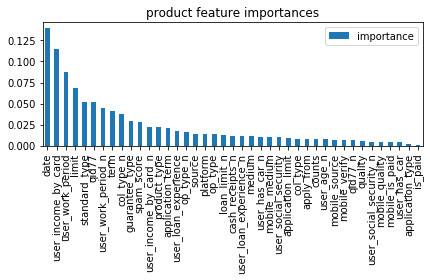

In [35]:
newdf = pd.DataFrame(best_est2.feature_importances_, index=features2.columns, 
    columns=['importance'])
newdf.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()